# Errors analysis

- [ ] histogram
- [ ] time dependence
- [ ] buoy type dependence
- [ ] buoy type dependence on time
- [ ] drogued or undrogued dependence
- [ ] gap dependence
- [ ] geographical repartition
- [ ] err_lon weird values

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import drifters.utils as ut

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5) # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.7:8787/status,
Dashboard: http://10.148.0.7:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.7:46930,Workers: 0
Dashboard: http://10.148.0.7:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# parameters
#drtype = "argos"
#drtype = "gps"

dl = 2 # degrees of longitude/latitude
dt = "year"
dt = "month"

di = 6 # subsampling (in time steps units, i.e. hours)

bandwidth = 0.1

In [4]:
# load data
df_argos = ut.load_gdp("argos", suffix=f"_filtered_b{bandwidth}")
df_argos = df_argos.where(df_argos!=-1.e+34).reset_index() #.persist()

df_gps = ut.load_gdp("gps", suffix=f"_filtered_b{bandwidth}")
df_gps = df_gps.where(df_gps!=-1.e+34).reset_index() #.persist()# ATTENTION : replace missing value -1.e+34 by Nan

In [9]:
df_gps.get_partition(0).head()

,index,time,rowsize,WMO,expno,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,...,inertial_phase,inertial_ve_real,inertial_ve_imag,inertial_vn_real,inertial_vn_imag,semidiurnal_phase,semidiurnal_ve_real,semidiurnal_ve_imag,semidiurnal_vn_real,semidiurnal_vn_imag
0,131969,2014-02-18 20:00:00,4556.0,6100654.0,7325.0,2014-02-18,38.793,0.657,2014-09-12,38.81,...,0.328439,-0.002888,-0.003392,0.000589,-0.002101,0.505868,8.314373e-07,0.000321,-0.003571,0.005423
1,131969,2014-02-18 21:00:00,4556.0,6100654.0,7325.0,2014-02-18,38.793,0.657,2014-09-12,38.81,...,0.656806,-0.003018,-0.003506,0.000597,-0.002242,1.011736,8.507465e-06,0.000346,-0.003600,0.005415
2,131969,2014-02-18 22:00:00,4556.0,6100654.0,7325.0,2014-02-18,38.793,0.657,2014-09-12,38.81,...,0.985115,-0.003150,-0.003620,0.000605,-0.002386,1.517604,1.605864e-05,0.000371,-0.003628,0.005405
3,131969,2014-02-18 23:00:00,4556.0,6100654.0,7325.0,2014-02-18,38.793,0.657,2014-09-12,38.81,...,1.313367,-0.003285,-0.003734,0.000612,-0.002531,2.023472,2.347032e-05,0.000397,-0.003655,0.005394
4,131969,2014-02-19 00:00:00,4556.0,6100654.0,7325.0,2014-02-18,38.793,0.657,2014-09-12,38.81,...,1.641561,-0.003423,-0.003849,0.000619,-0.002679,2.529340,3.072781e-05,0.000424,-0.003680,0.005381


In [7]:
df_gps.columns

Index(['index', 'time', 'rowsize', 'WMO', 'expno', 'deploy_date', 'deploy_lat',
       'deploy_lon', 'end_date', 'end_lat', 'end_lon', 'drogue_lost_date',
       'typedeath', 'typebuoy', 'lon', 'lat', 'lon360', 've', 'vn', 'err_lat',
       'err_lon', 'err_ve', 'err_vn', 'gap', 'low_omega', 'inertial_omega',
       'semidiurnal_omega', 'low_phase', 'low_ve_real', 'low_ve_imag',
       'low_vn_real', 'low_vn_imag', 'inertial_phase', 'inertial_ve_real',
       'inertial_ve_imag', 'inertial_vn_real', 'inertial_vn_imag',
       'semidiurnal_phase', 'semidiurnal_ve_real', 'semidiurnal_ve_imag',
       'semidiurnal_vn_real', 'semidiurnal_vn_imag'],
      dtype='object')

## Histogram  of positional errors in °

Text(0.5, 0, 'error [°]')

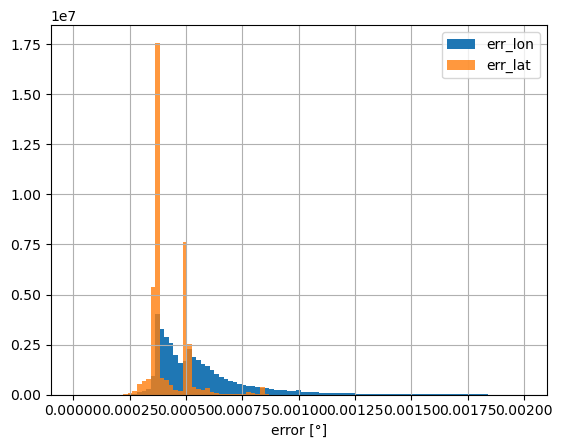

In [12]:
err_lon = df_gps['err_lon'].compute()
err_lat = df_gps['err_lat'].compute()
err_lon_hist = err_lon.hist(bins=np.linspace(0,2e-3,100), label = 'err_lon')
err_lat_hist = err_lat.hist(bins=np.linspace(0,2e-3,100), label = 'err_lat', alpha=0.8)
plt.legend()
plt.xlabel('error [°]')

Text(0.5, 0, 'error [°]')

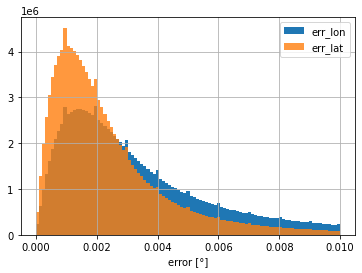

In [9]:
err_lon = df_argos['err_lon'].compute()
err_lat = df_argos['err_lat'].compute()
err_lon_hist = err_lon.hist(bins=np.linspace(0,1e-2,100), label = 'err_lon')
err_lat_hist = err_lat.hist(bins=np.linspace(0,1e-2,100), label = 'err_lat', alpha=0.8)
plt.legend()
plt.xlabel('error [°]')

<AxesSubplot:xlabel='err_lon', ylabel='err_lat'>

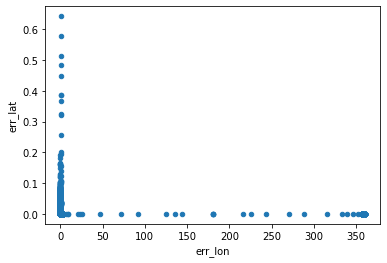

In [10]:
df_gps[['err_lon', 'err_lat']].compute().plot.scatter('err_lon', 'err_lat')
#plt.legend()
#plt.xlabel('error [°]')

<AxesSubplot:xlabel='err_lon', ylabel='err_lat'>

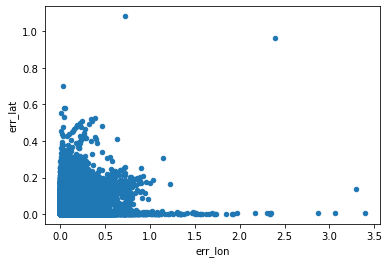

In [12]:
df_argos[['err_lon', 'err_lat']].compute().plot.scatter('err_lon', 'err_lat')
#plt.legend()
#plt.xlabel('error [°]')

## Histogram  of errors in m

In [13]:
def dlonlat_dlonlatm(dlon, dlat, lat):
    """ return the error distance in m from the error in degree"""
    R=6371e3
    return R*np.arccos(np.sin(lat)**2 + (np.cos(lat)**2)*np.cos(dlon)), R*dlat

In [14]:
def add_errm(df):
    f = dlonlat_dlonlatm( df['err_lon']*np.pi/180, df['err_lat']*np.pi/180, df['lat']*np.pi/180)
    df['err_lonm'] = f[0]
    df['err_latm'] = f[1]

In [15]:
add_errm(df_gps)
add_errm(df_argos)

Text(0.5, 0, 'error [m]')

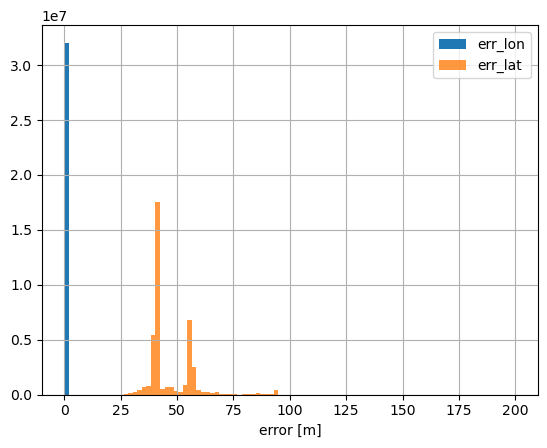

In [26]:
err_lonm = df_gps['err_lonm'].compute()
err_latm = df_gps['err_latm'].compute()
err_lonm_hist = err_lonm.hist(bins=np.linspace(0,200,100), label = 'err_lon')
err_latm_hist = err_latm.hist(bins=np.linspace(0,200,100), label = 'err_lat', alpha=0.8)
plt.legend()
plt.xlabel('error [m]')

In [18]:
err_lonm

0                 NaN
1            0.000000
2            0.000000
3         2199.695801
4            0.000000
             ...     
253869    2199.695801
253870       0.000000
253871       0.000000
253872       0.000000
253873       0.000000
Name: err_lonm, Length: 41635507, dtype: float32

In [19]:
print( f' GPS : \n err_lon : mean = {err_lonm.mean()}, std = {err_lonm.std()} '+ 
      f'\n err_lat : mean = {err_latm.mean()}, std = {err_latm.std()}'+
      f'\n norm : mean = {(np.sqrt(err_lonm**2 +err_latm**2)).mean()}, std = {(np.sqrt(err_lonm**2 +err_latm**2)).std()} '
      +f'\n sigv = {np.sqrt(2) * (np.sqrt(err_lonm**2 +err_latm**2)).std()/3600}'
      +f'\n siga = {2 * (np.sqrt(err_lonm**2 +err_latm**2)).mean()/(3600**2)}')

 GPS : 
 err_lon : mean = 418.19464111328125, std = 4654.19921875 
 err_lat : mean = 47.823577880859375, std = 46.31322479248047
 norm : mean = 457.3644104003906, std = 4650.99658203125 
 sigv = 1.827084012460973
 siga = 7.058092753092448e-05


Text(0.5, 0, 'error [m]')

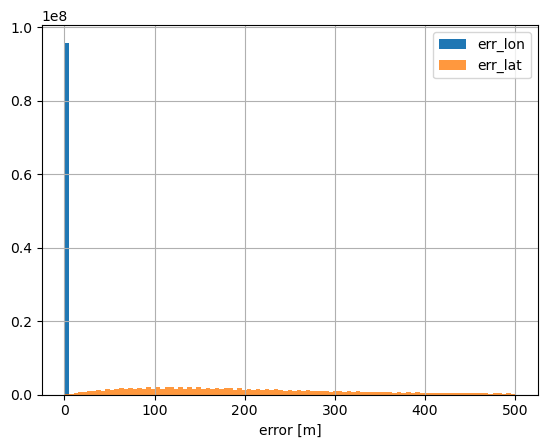

In [22]:
err_lonm = df_argos['err_lonm'].compute()
err_latm = df_argos['err_latm'].compute()
err_lonm_hist = err_lonm.hist(bins=np.linspace(0,500,100), label = 'err_lon')
err_latm_hist = err_latm.hist(bins=np.linspace(0,500,100), label = 'err_lat', alpha=0.8)
plt.legend()
plt.xlabel('error [m]')

In [23]:
print( f' Argos : \n errlon : mean = {err_lonm.mean()}, std = {err_lonm.std()} '+ 
      f'\n err_lat : mean = {err_latm.mean()}, std = {err_latm.std()}'+
      f'\n norm : mean = {(np.sqrt(err_lonm**2 +err_latm**2)).mean()}, std = {(np.sqrt(err_lonm**2 +err_latm**2)).std()} '
     +f'\n sigv = {np.sqrt(2) * (np.sqrt(err_lonm**2 +err_latm**2)).mean()/3600}'
     +f'\n siga = {2 * (np.sqrt(err_lonm**2 +err_latm**2)).mean()/(3600**2)}')

 Argos : 
 errlon : mean = 480.2281188964844, std = 982.60888671875 
 err_lat : mean = 313.77703857421875, std = 442.8861083984375
 norm : mean = 732.1641235351562, std = 978.9685668945312 
 sigv = 0.2876212314962301
 siga = 0.0001129882906690056


## Histogram  of velocities errors 

<AxesSubplot:xlabel='err_ve', ylabel='err_vn'>

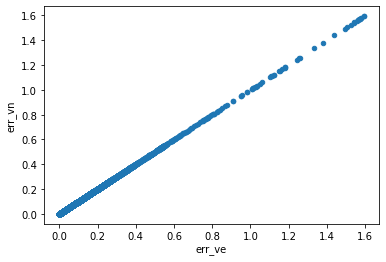

In [11]:
df_gps[['err_ve', 'err_vn']].compute().plot.scatter('err_ve', 'err_vn')
#plt.legend()
#plt.xlabel('error [°]')

In [13]:
err_lon

0         0.00062
1         0.00098
2         0.00081
3         0.00066
4         0.00057
           ...   
253869    0.00047
253870    0.00064
253871    0.00046
253872    0.00072
253873    0.00108
Name: err_lon, Length: 41635507, dtype: float32

<AxesSubplot:xlabel='err_ve', ylabel='err_vn'>

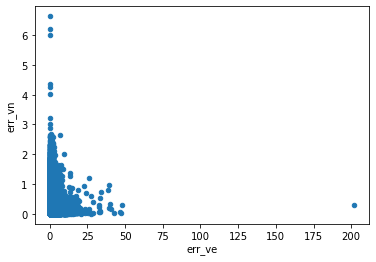

In [13]:
df_argos[['err_ve', 'err_vn']].compute().plot.scatter('err_ve', 'err_vn')
#plt.legend()
#plt.xlabel('error [°]')

Text(0.5, 0, 'error [m/s]')

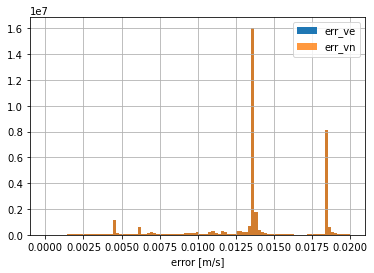

In [10]:
err_ve = df_gps['err_ve'].compute()
err_vn = df_gps['err_vn'].compute()
err_ve_hist = err_ve.hist(bins=np.linspace(0,2e-2,100), label = 'err_ve')
err_vn_hist = err_vn.hist(bins=np.linspace(0,2e-2,100), label = 'err_vn', alpha=0.8)
plt.legend()
plt.xlabel('error [m/s]')

Text(0.5, 0, 'error [m/s]')

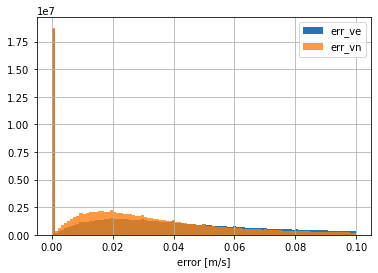

In [7]:
err_ve = df_argos['err_ve'].compute()
err_vn = df_argos['err_vn'].compute()
err_ve_hist = err_ve.hist(bins=np.linspace(0,1e-1,100), label = 'err_ve')
err_vn_hist = err_vn.hist(bins=np.linspace(0,1e-1,100), label = 'err_vn', alpha=0.8)
plt.legend()
plt.xlabel('error [m/s]')

In [14]:
err_ve0 = df_argos[df_argos['err_ve']==0 ].compute()

In [17]:
err_ve0[['lon', 'lat', 'err_ve','err_vn', 'gap', 'typebuoy']]

,lon,lat,err_ve,err_vn,gap,typebuoy
728,-46.657909,48.183151,0.0,0.0266,3974.0,b'SVP '
9632,-155.385880,14.152170,0.0,0.0178,27389.0,b'SVP '
9633,-155.396927,14.154260,0.0,0.0179,27389.0,b'SVP '
9634,-155.407959,14.156660,0.0,0.0180,27389.0,b'SVP '
9635,-155.419006,14.159170,0.0,0.0181,27389.0,b'SVP '
...,...,...,...,...,...,...
40679,-91.062019,25.232800,0.0,0.0000,6048.0,b'SVP '
40680,-91.056427,25.233021,0.0,0.0000,5357.0,b'SVP '
40681,-91.054359,25.227909,0.0,0.0000,5357.0,b'SVP '
40682,-91.048988,25.221300,0.0,0.0000,5962.0,b'SVP '


Text(0.5, 0, 'gap [min]')

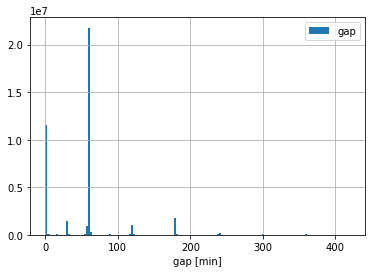

In [6]:
gap = df_gps['gap'].compute()
gap_hist = (gap/60).hist(bins=np.linspace(0,60*7,150), label = 'gap')
plt.legend()
plt.xlabel('gap [min]')

Text(0.5, 0, 'gap [min]')

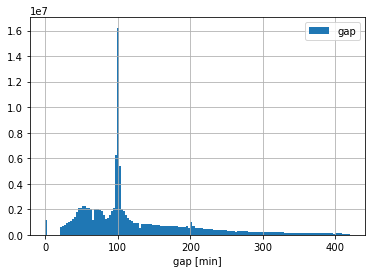

In [7]:
gap = df_argos['gap'].compute()
gap_hist = (gap/60).hist(bins=np.linspace(0,60*7,150), label = 'gap')
plt.legend()
plt.xlabel('gap [min]')

## Errors dependance on year

In [6]:
def error_dep2_year(df):
    t_start = df["time"].min().compute()
    t_end = df["time"].max().compute()
    print(df['err_lon'].max().compute())
    delta_t = (t_end - t_start)/pd.Timedelta('1D')
    year_bins = pd.date_range(t_start, t_end, freq='1Y') # yearly binning
    df['year_cut'] = df["time"].map_partitions(pd.cut, year_bins)
    mean_year = (df[['err_lon', 'err_lat', 'err_ve', 'err_vn']]
         .groupby(df.year_cut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['err_lon', 'err_lat', 'err_ve', 'err_vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean_year['year'] = mean_year.index.to_series().apply(lambda d: d.left)
    mean_year = mean_year.set_index('year')

    ds_year = (mean_year
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds_year

In [7]:
ds_year_argos = error_dep2_year(df_argos)
ds_year_gps = error_dep2_year(df_gps[df_gps['err_lon']<0.02])

3.393850088119507
0.019990000873804092


In [8]:
ds_year_gps

<xarray.Dataset>
Dimensions:       (year: 18)
Coordinates:
  * year          (year) datetime64[ns] 2001-12-31T02:00:00 ... 2018-12-31T02...
Data variables:
    mean_err_lon  (year) float64 nan nan nan ... 0.0005607 0.0005749 0.0006039
    mean_err_lat  (year) float64 nan nan nan ... 0.0004262 0.0004257 0.0004373
    mean_err_ve   (year) float64 nan nan nan nan ... 0.01698 0.01594 0.01525
    mean_err_vn   (year) float64 nan nan nan nan ... 0.01698 0.01594 0.01525

Text(0, 0.5, 'error [°]')

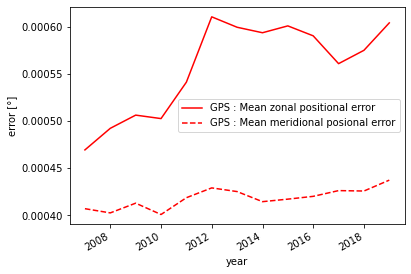

In [9]:
ds_year_gps.mean_err_lon.plot(label='GPS : Mean zonal positional error', color='red')
ds_year_gps.mean_err_lat.plot(label='GPS : Mean meridional posional error', color='red', ls='--')
plt.legend()
plt.ylabel('error [°]')

Text(0, 0.5, 'error [°]')

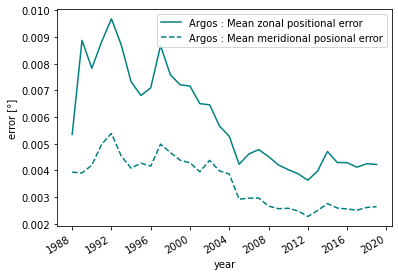

In [10]:
ds_year_argos.mean_err_lon.plot(label='Argos : Mean zonal positional error', color='teal')
ds_year_argos.mean_err_lat.plot(label='Argos : Mean meridional posional error', color='teal', ls='--')
plt.legend()
plt.ylabel('error [°]')

Text(0, 0.5, 'error [°]')

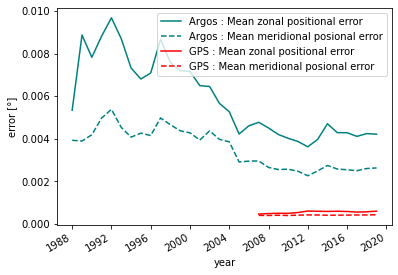

In [11]:
ds_year_argos.mean_err_lon.plot(label='Argos : Mean zonal positional error', color='teal')
ds_year_argos.mean_err_lat.plot(label='Argos : Mean meridional posional error', color='teal', ls='--')
ds_year_gps.mean_err_lon.plot(label='GPS : Mean zonal positional error', color='red')
ds_year_gps.mean_err_lat.plot(label='GPS : Mean meridional posional error', color='red', ls='--')
plt.legend()
plt.ylabel('error [°]')

Text(0, 0.5, 'error [m/s]')

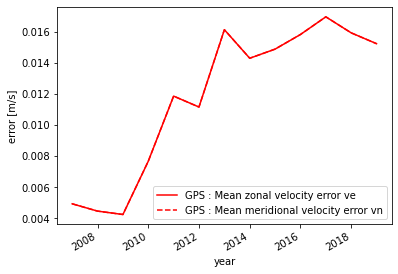

In [12]:
ds_year_gps.mean_err_ve.plot(label='GPS : Mean zonal velocity error ve', color='red')
ds_year_gps.mean_err_vn.plot(label='GPS : Mean meridional velocity error vn', color='red', ls='--')
plt.legend()
plt.ylabel('error [m/s]')

Text(0, 0.5, 'error [m/s]')

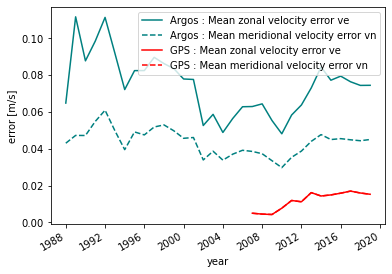

In [13]:
ds_year_argos.mean_err_ve.plot(label='Argos : Mean zonal velocity error ve', color='teal')
ds_year_argos.mean_err_vn.plot(label='Argos : Mean meridional velocity error vn', color='teal', ls='--')
ds_year_gps.mean_err_ve.plot(label='GPS : Mean zonal velocity error ve', color='red')
ds_year_gps.mean_err_vn.plot(label='GPS : Mean meridional velocity error vn', color='red', ls='--')
plt.legend()
plt.ylabel('error [m/s]')

## Errors dependance on buoy type

In [26]:
def error_dep2_buoytype(df):
    mean_btype = (df[['err_lon', 'err_lat', 'err_ve', 'err_vn']]
         .groupby(df.typebuoy)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['err_lon', 'err_lat', 'err_ve', 'err_vn']})
         #.to_frame() ALREADY A DATAFRAME
        )

    ds_year = (mean_btype
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds_year

In [27]:
#ds_btype_argos = error_dep2_buoytype(df_argos)
#ds_btype_gps = error_dep2_buoytype(df_gps)
ds_btype_gps_cut = error_dep2_buoytype(df_gps[df_gps['err_lon']<0.02])

In [19]:
ds_btype_gps

<xarray.Dataset>
Dimensions:       (typebuoy: 8)
Coordinates:
  * typebuoy      (typebuoy) object b'SVP    ' b'SVPB   ' ... b'SVPBS  '
Data variables:
    mean_err_lon  (typebuoy) float64 0.001073 0.001512 ... 0.0004909 0.0004823
    mean_err_lat  (typebuoy) float64 0.000424 0.0004332 ... 0.0004166 0.0004419
    mean_err_ve   (typebuoy) float64 0.01603 0.01458 ... 0.005357 0.02479
    mean_err_vn   (typebuoy) float64 0.01603 0.01458 ... 0.005357 0.02479

In [28]:
#ds_btype_argos['typebuoy']=np.array(['SVP', 'SVPB', 'unknown', 'SVPBS', 'SVPBW','SVPS',
#       'SVPW', 'Unknown'])
#ds_btype_gps['typebuoy']=np.array(['SVP', 'SVPB', 'SVPBW', 'SVPV', 'SVPS', 'SVPG',
#       'SVPBV', 'SVPBS'])
ds_btype_gps_cut['typebuoy']=np.array(['SVP', 'SVPB', 'SVPBW', 'SVPV', 'SVPS', 'SVPG',
       'SVPBV', 'SVPBS'])

In [30]:
#ds_btype_argos = ds_btype_argos.sortby('typebuoy')
#ds_btype_gps = ds_btype_gps.sortby('typebuoy')
ds_btype_gps_cut = ds_btype_gps_cut.sortby('typebuoy')

Text(0, 0.5, 'error [°]')

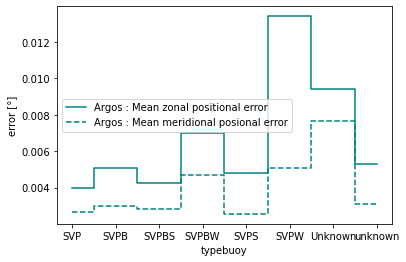

In [23]:
ds_btype_argos.mean_err_lon.plot.step(where='mid',label='Argos : Mean zonal positional error', color='teal')
ds_btype_argos.mean_err_lat.plot.step(where='mid',label='Argos : Mean meridional posional error', color='teal', ls='--')
plt.legend()
plt.ylabel('error [°]')

Text(0, 0.5, 'error [°]')

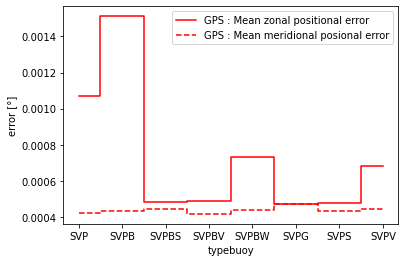

In [24]:
ds_btype_gps.mean_err_lon.plot.step(where='mid',label='GPS : Mean zonal positional error', color='red')
ds_btype_gps.mean_err_lat.plot.step(where='mid',label='GPS : Mean meridional posional error', color='red', ls='--')
plt.legend()
plt.ylabel('error [°]')

Text(0, 0.5, 'error [°]')

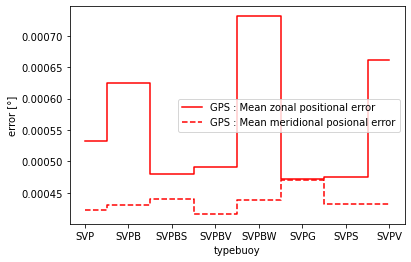

In [31]:
ds_btype_gps_cut.mean_err_lon.plot.step(where='mid',label='GPS : Mean zonal positional error', color='red')
ds_btype_gps_cut.mean_err_lat.plot.step(where='mid',label='GPS : Mean meridional posional error', color='red', ls='--')
plt.legend()
plt.ylabel('error [°]')

In [33]:
def error_dep2_btype2(df1, err_var, err_max=0):#diviser par le nombre 
    df=df1
    if err_max ==0:
        err_max = df[err_var].max().compute()
    bins = np.linspace(0, err_max, 100) # binning
    df['err_cut'] = df[err_var].map_partitions(pd.cut, bins)
    count = df.groupby('err_cut').count()['ve']
    
    df=df[['err_cut', 've', 'typebuoy']].compute() #HOW NOT TO COMPUTE HERE ???
    df_pivot =pd.pivot_table(df, index='err_cut', values='ve', columns='typebuoy', aggfunc='count')
    df_pivot['total']=count
    df_pivot = df_pivot.iloc[:, :-1].div(df_pivot['total'], axis=0)
    a = df_pivot.index.to_series().apply(lambda d: np.round(d.mid,4))
    df_pivot = df_pivot.set_index(a)
    return df_pivot

In [37]:
df_btype2_argos = error_dep2_btype2(df_argos, 'err_lon', 1.5e-2)
#df_btype2_gps = error_dep2_btype2(df_gps, 'err_lon')
df_btype2_gps_cut = error_dep2_btype2(df_gps, 'err_lon', 2e-3)

Text(0.5, 1.0, "Evolution des proportions du type de bouée en fonction de l'erreur")

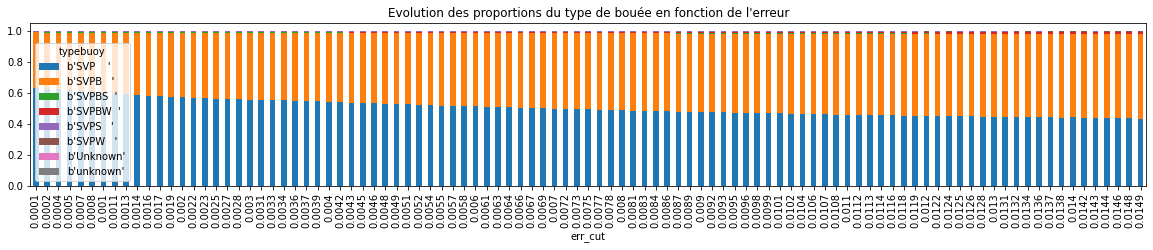

In [38]:
df_btype2_argos.plot.bar(stacked=True, figsize=(20,3))
plt.title("Evolution des proportions du type de bouée en fonction de l'erreur")

Text(0.5, 1.0, "Evolution des proportions du type de bouée en fonction de l'erreur")

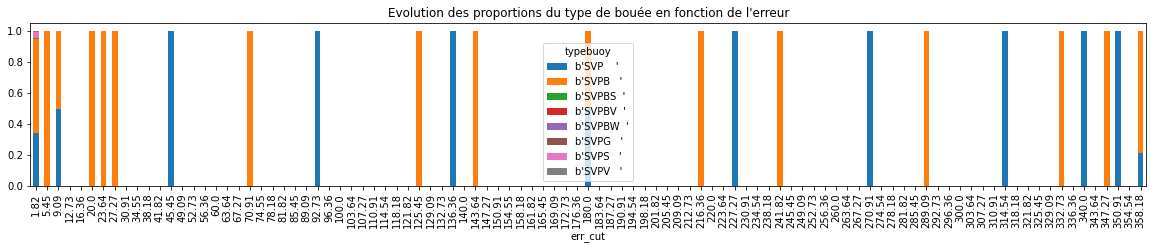

In [31]:
df_btype2_gps.plot.bar(stacked=True, figsize=(20,3))
plt.title("Evolution des proportions du type de bouée en fonction de l'erreur")

Text(0.5, 1.0, "Evolution des proportions du type de bouée en fonction de l'erreur")

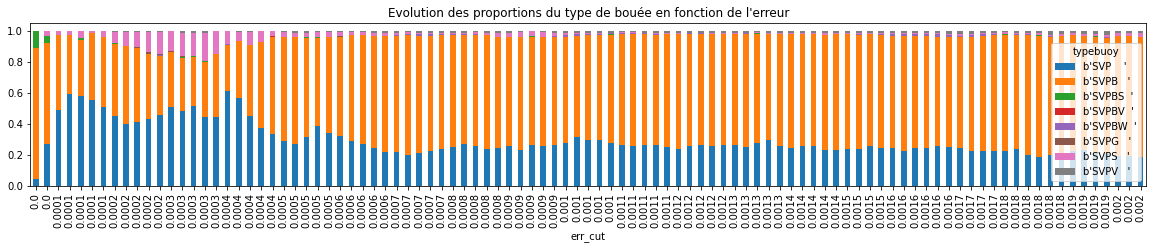

In [39]:
df_btype2_gps_cut.plot.bar(stacked=True, figsize=(20,3))
plt.title("Evolution des proportions du type de bouée en fonction de l'erreur")

## Buoy type dependending on the year

In [40]:
def btype_dep2_year(df):
    t_start = df["time"].min().compute()
    t_end = df["time"].max().compute()
    delta_t = (t_end - t_start)/pd.Timedelta('1D')
    year_bins = pd.date_range(t_start, t_end, freq='1Y') # yearly binning
    df['year_cut'] = df["time"].map_partitions(pd.cut, year_bins)
    df=df[['year_cut', 've', 'typebuoy']].compute() #HOW NOT TO COMPUTE HERE ???
    df_pivot =pd.pivot_table(df, index='year_cut', values='ve', columns='typebuoy', aggfunc='count')
    a = df_pivot.index.to_series().apply(lambda d: d.left)
    df_pivot = df_pivot.set_index(a)
    return df_pivot

In [41]:
df_btypeyear_argos = btype_dep2_year(df_argos)
df_btypeyear_gps = btype_dep2_year(df_gps)

<AxesSubplot:xlabel='year_cut'>

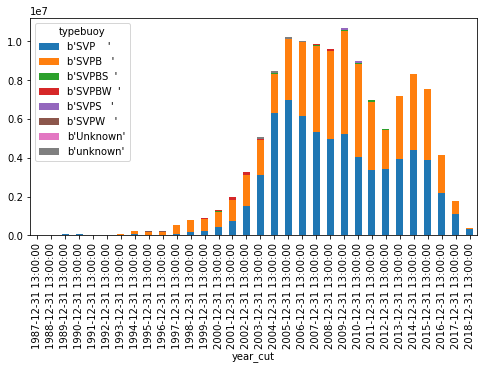

In [43]:
df_btypeyear_argos.plot.bar(stacked=True, figsize=(8,4))

<AxesSubplot:xlabel='year_cut'>

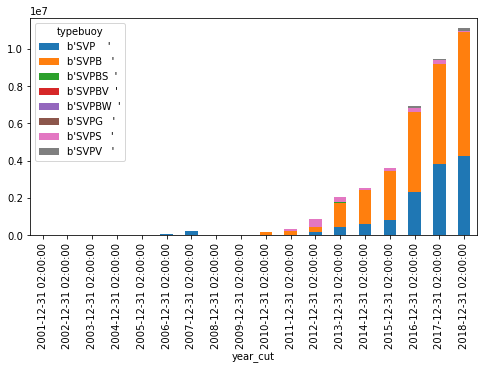

In [44]:
df_btypeyear_gps.plot.bar(stacked=True, figsize=(8,4))

## Errors dependance on drogued/undrogued

In [22]:
#Create bool variable defining if the drogued is still attached or not
df_gps['drogued']=(df_gps['time']<df_gps['drogue_lost_date'])
df_argos['drogued']=(df_argos['time']<df_argos['drogue_lost_date'])

In [38]:
d_drogue = df_gps[df_gps['drogued']][['time', 'drogue_lost_date']]
d_undrogue = df_gps[df_gps['drogued']==False][['time', 'drogue_lost_date']]

In [48]:
d_drogue.tail(20)#verification

,time,drogue_lost_date
253037,2020-02-26 04:00:00,2020-02-27
253038,2020-02-26 05:00:00,2020-02-27
253039,2020-02-26 06:00:00,2020-02-27
253040,2020-02-26 07:00:00,2020-02-27
253041,2020-02-26 08:00:00,2020-02-27
253042,2020-02-26 09:00:00,2020-02-27
253043,2020-02-26 10:00:00,2020-02-27
253044,2020-02-26 11:00:00,2020-02-27
253045,2020-02-26 12:00:00,2020-02-27
253046,2020-02-26 13:00:00,2020-02-27


In [51]:
d_undrogue.tail(20)#verification

,time,drogue_lost_date
253854,2020-03-31 05:00:00,2020-02-27
253855,2020-03-31 06:00:00,2020-02-27
253856,2020-03-31 07:00:00,2020-02-27
253857,2020-03-31 08:00:00,2020-02-27
253858,2020-03-31 09:00:00,2020-02-27
253859,2020-03-31 10:00:00,2020-02-27
253860,2020-03-31 11:00:00,2020-02-27
253861,2020-03-31 12:00:00,2020-02-27
253862,2020-03-31 13:00:00,2020-02-27
253863,2020-03-31 14:00:00,2020-02-27


In [25]:
def error_dep2_drogue(df):
    mean_drogued = (df[['err_lon', 'err_lat', 'err_ve', 'err_vn']]
         .groupby(df.drogued)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['err_lon', 'err_lat', 'err_ve', 'err_vn']})
         #.to_frame() ALREADY A DATAFRAME
        )

    ds = (mean_drogued
          #.drop(columns=["year",])
          .to_xarray()
         )
    return ds

In [41]:
ds_drogue_gps = error_dep2_drogue(df_gps)
ds_drogue_argos = error_dep2_drogue(df_argos)

In [27]:
ds_drogue_gps

<xarray.Dataset>
Dimensions:       (drogued: 2)
Coordinates:
  * drogued       (drogued) object False True
Data variables:
    mean_err_lon  (drogued) float64 0.001219 0.001408
    mean_err_lat  (drogued) float64 0.0004247 0.0004357
    mean_err_ve   (drogued) float64 0.01522 0.01589
    mean_err_vn   (drogued) float64 0.01522 0.01589

In [42]:
ds_drogue_argos

<xarray.Dataset>
Dimensions:       (drogued: 2)
Coordinates:
  * drogued       (drogued) object False True
Data variables:
    mean_err_lon  (drogued) float64 0.004297 0.004838
    mean_err_lat  (drogued) float64 0.002733 0.002989
    mean_err_ve   (drogued) float64 0.06408 0.06549
    mean_err_vn   (drogued) float64 0.03934 0.03847

## Errors dependance on the gap

In [47]:
def error_dep2_gap(df):
    gap_min = (df["gap"].min()).compute()
    gap_max = (df["gap"].max()).compute()
    #delta_gap = (gap_min - t_start)/pd.Timedelta('1H')
    gap_bins = np.arange(gap_min, gap_max, 3600) # hourly binning
    df['gap_cut'] = df["gap"].map_partitions(pd.cut, gap_bins)
    mean_gap = (df[['err_lon', 'err_lat', 'err_ve', 'err_vn']]
         .groupby(df.gap_cut)
         .mean()
         .compute()
         .rename(columns={l:'mean_'+ l for l in ['err_lon', 'err_lat', 'err_ve', 'err_vn']})
         #.to_frame() ALREADY A DATAFRAME
        )
    mean_gap['gap'] = mean_gap.index.to_series().apply(lambda d: d.mid)
    mean_gap = mean_gap.set_index('gap')

    ds = (mean_gap
          #.drop(columns=["year",])
          .to_xarray()
         )
    ds['gap']=ds['gap']/3600
    return ds

In [53]:
ds_gap_argos = error_dep2_gap(df_argos)
ds_gap_gps = error_dep2_gap(df_gps)
ds_gap_gps_cut = error_dep2_gap(df_gps[df_gps['err_lon']<0.02])

In [54]:
ds_gap_argos

<xarray.Dataset>
Dimensions:       (gap: 11)
Coordinates:
  * gap           (gap) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5
Data variables:
    mean_err_lon  (gap) float64 0.003982 0.004137 0.004089 ... 0.01132 0.01107
    mean_err_lat  (gap) float64 0.002129 0.002496 0.002724 ... 0.009676 0.009413
    mean_err_ve   (gap) float64 0.1066 0.06553 0.04548 ... 0.03531 0.0322
    mean_err_vn   (gap) float64 0.05644 0.04023 0.03054 ... 0.02869 0.02634

Text(0.5, 0, 'gap [h]')

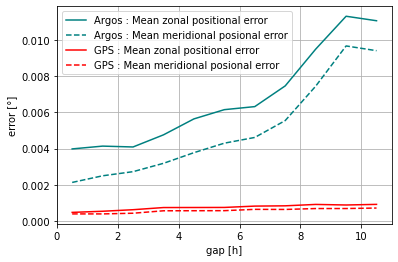

In [55]:
ds_gap_argos.mean_err_lon.plot(label='Argos : Mean zonal positional error', color='teal')
ds_gap_argos.mean_err_lat.plot(label='Argos : Mean meridional posional error', color='teal', ls='--')
ds_gap_gps_cut.mean_err_lon.plot(label='GPS : Mean zonal positional error', color='red')
ds_gap_gps_cut.mean_err_lat.plot(label='GPS : Mean meridional posional error', color='red', ls='--')
plt.legend()
plt.grid()
plt.ylabel('error [°]')
plt.xlabel('gap [h]')

Text(0.5, 0, 'gap [h]')

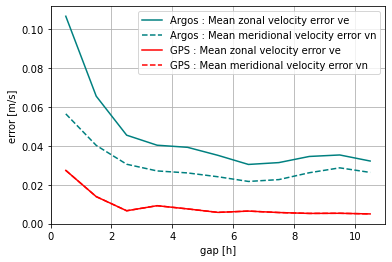

In [56]:
ds_gap_argos.mean_err_ve.plot(label='Argos : Mean zonal velocity error ve', color='teal')
ds_gap_argos.mean_err_vn.plot(label='Argos : Mean meridional velocity error vn', color='teal', ls='--')
ds_gap_gps.mean_err_ve.plot(label='GPS : Mean zonal velocity error ve', color='red')
ds_gap_gps.mean_err_vn.plot(label='GPS : Mean meridional velocity error vn', color='red', ls='--')
plt.legend()
plt.grid()
plt.ylabel('error [m/s]')
plt.xlabel('gap [h]')

## Geographical repartition

In [19]:
# geographical bins
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

In [20]:
dx_km = 200

def add_geodata(df):

    df = df.reset_index()
    
    #df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    #df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)
    df['lon'] = df["lon_cut"].apply(lambda r: r.mid)
    df['lat'] = df["lat_cut"].apply(lambda r: r.mid)

    def build_polygon(r):
        lon0, lon1 = r["lon_cut"].left, r["lon_cut"].right
        lat0, lat1 = r["lat_cut"].left, r["lat_cut"].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    dx = dx_km*1e3 # 200km
    df['area'] = df.to_crs(crs = 'epsg:3857').area /(dx**2) # 
    
    return df

In [21]:
def geo_stat(df1):
    df=df1
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
    df = (df[["err_lon", "err_lat", "err_ve", "err_vn", 'gap']]
       .groupby([df.lon_cut, df.lat_cut])
       .mean()
       .compute()
       .rename(columns={l:'mean_'+ l for l in ['err_lon', 'err_lat', 'err_ve', 'err_vn', 'gap']})
      )
    df = add_geodata(df)
    
    ds = (df
      .drop(columns=['Coordinates', "lon_cut", "lat_cut"])
      .set_index(['lon', 'lat'])
      .to_xarray()
     )
    return ds

In [22]:
ds_geo_gps = geo_stat(df_gps)

In [23]:
ds_geo_gps

<xarray.Dataset>
Dimensions:       (lon: 179, lat: 89)
Coordinates:
  * lon           (lon) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat           (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 81.0 83.0 85.0 87.0
Data variables:
    mean_err_lon  (lon, lat) float64 nan nan nan nan ... 0.003556 0.005162 nan
    mean_err_lat  (lon, lat) float64 nan nan nan nan ... 0.0004407 0.0004115 nan
    mean_err_ve   (lon, lat) float64 nan nan nan nan ... 0.01663 0.01422 nan
    mean_err_vn   (lon, lat) float64 nan nan nan nan ... 0.01663 0.01422 nan
    mean_gap      (lon, lat) float64 nan nan nan nan ... 2.503e+03 4.12e+03 nan
    area          (lon, lat) float64 1.206e+03 24.62 14.41 ... 10.24 14.41 24.62

Text(0.5, 0.98, 'Average errors per 200km^2 ')

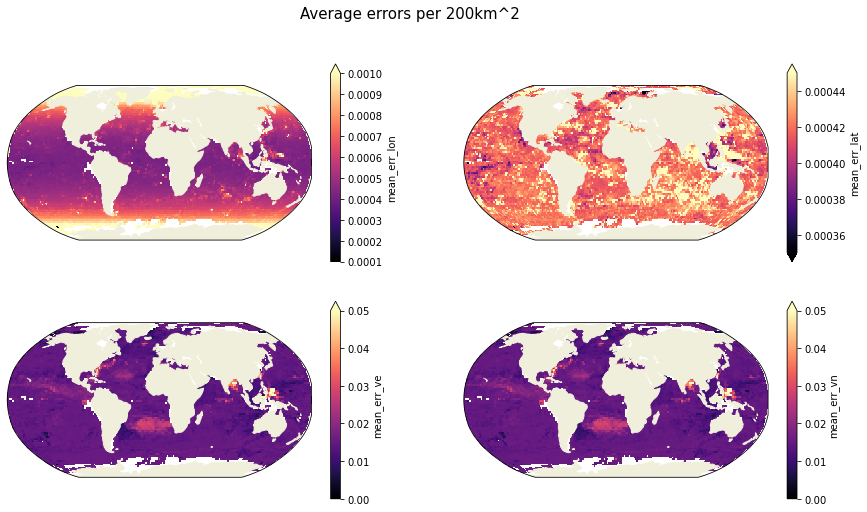

In [27]:
figsize = (15,8)
#crs = ccrs.Mollweide()
crs = ccrs.Robinson()
#crs = ccrs.EqualEarth()
#crs = ccrs.Geodetic()

fig = plt.figure(figsize=figsize)
lis=['mean_err_lon','mean_err_lat', 'mean_err_ve', 'mean_err_vn']
Vmax=[1e-3, 4.5e-4]
Vmin=[1e-4, 3.5e-4]
for n in range(2):
    ax = fig.add_subplot(2,2,n+1, projection=crs)

    ds_geo_gps[lis[n]].plot(x='lon', 
                     y='lat',
                     cmap='magma',
                     vmax=Vmax[n],
                     vmin=Vmin[n],
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    ax.add_feature(cfeature.LAND, zorder=1)
for n in range(2, 4):
    ax = fig.add_subplot(2,2,n+1, projection=crs)

    ds_geo_gps[lis[n]].plot(x='lon', 
                     y='lat',
                     cmap='magma',
                     vmax=0.05,
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    ax.add_feature(cfeature.LAND, zorder=1)
fig.suptitle(f'Average errors per {dx_km}km^2 ', fontsize=15)

Text(0.5, 1.0, 'Average gap per 200km^2 ')

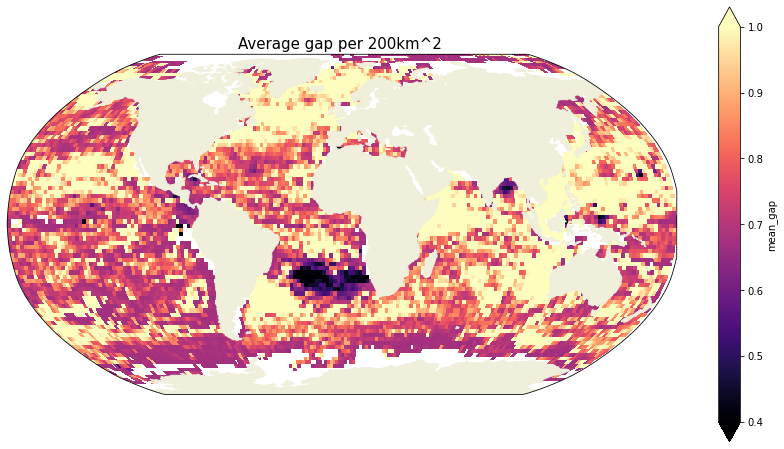

In [35]:
figsize = (15,8)
#crs = ccrs.Mollweide()
crs = ccrs.Robinson()
#crs = ccrs.EqualEarth()
#crs = ccrs.Geodetic()

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(111, projection=crs)

(ds_geo_gps['mean_gap']/3600).plot(x='lon', 
                 y='lat',
                 cmap='magma',
                 vmax=1,
                 vmin = 0.4,
                 ax=ax,
                 transform=ccrs.PlateCarree(),
                )
ax.add_feature(cfeature.LAND, zorder=1)

ax.set_title(f'Average gap per {dx_km}km^2 ', fontsize=15)

## Valeurs abhérentes err_lon

In [46]:
df_gps_w = df_gps[df_gps['err_lon']>0.02]

In [48]:
count_w = df_gps_w.groupby('typebuoy').count()['time'].rename('weird')
count_total = df_gps.groupby('typebuoy').count()['time'].rename('total')

In [59]:
count_w.compute()

typebuoy
b'SVP    '     502
b'SVPB   '    2378
b'SVPS   '      48
b'SVPV   '     166
b'SVPBS  '       2
Name: weird, dtype: int64

In [60]:
count_total.compute()

typebuoy
b'SVP    '    14000656
b'SVPB   '    24559205
b'SVPBW  '       70728
b'SVPV   '      319162
b'SVPS   '     1517932
b'SVPG   '        4060
b'SVPBV  '       20043
b'SVPBS  '       37330
Name: total, dtype: int64

In [51]:
(count_w/count_total).compute()

typebuoy
b'SVP    '    0.000036
b'SVPB   '    0.000097
b'SVPBS  '    0.000054
b'SVPBV  '         NaN
b'SVPBW  '         NaN
b'SVPG   '         NaN
b'SVPS   '    0.000032
b'SVPV   '    0.000520
dtype: float64

In [52]:
ds_btype_gps_w = error_dep2_buoytype(df_gps_w)

In [55]:
ds_btype_gps_w['typebuoy']

<xarray.DataArray 'typebuoy' (typebuoy: 5)>
array([b'SVP    ', b'SVPB   ', b'SVPS   ', b'SVPV   ', b'SVPBS  '],
      dtype=object)
Coordinates:
  * typebuoy  (typebuoy) object b'SVP    ' b'SVPB   ' ... b'SVPV   ' b'SVPBS  '

In [56]:
ds_btype_gps_w['typebuoy']=np.array(['SVP', 'SVPB', 'SVPS','SVPV','SVPBS'])

Text(0, 0.5, 'error [°]')

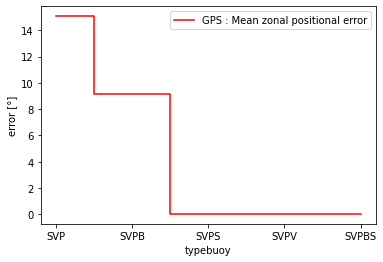

In [58]:
ds_btype_gps_w.mean_err_lon.plot.step(where='mid',label='GPS : Mean zonal positional error', color='red')
plt.legend()
plt.ylabel('error [°]')

In [27]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min